In [580]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [581]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [582]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [583]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [584]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs

In [585]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

In [586]:
def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [587]:
class RadiationModelImplicit:
    """Class defining a radiation model"""
    
    def __init__(self, grid, T, To, sigma, epsilon):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._To = To
        self._sigma = sigma
        self._epsilon = epsilon
        
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._sigma*self._epsilon*self._grid.Ao*(((self._T[1:-1]*self._T[1:-1]*self._T[1:-1]*self._T[1:-1])- (self._To*self._To*self._To*self._To))) 
        # Calculate the linearization coefficients
        coeffP = 4*self._sigma*self._epsilon*self._grid.Ao*(self._T[1:-1]*self._T[1:-1]*self._T[1:-1])
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

# Determination of Required Number of Iterations for Convergence for Steel

# Convergence Criteria 1e-8

In [588]:
def problem4implicitsteel(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-8

    # Define thermophysical properties
    k = 60

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [589]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= 4*(i) + 6
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitsteel(ncv))

Iteration = 0; Max. Resid. = 53.99811; Avg. Resid. = 12.001260000000002
Iteration = 1; Max. Resid. = 0.3187026773082414; Avg. Resid. = 0.08469556071959865
Iteration = 2; Max. Resid. = 0.00011295475821956891; Avg. Resid. = 4.375138371529077e-05
Iteration = 3; Max. Resid. = 5.190392560194823e-11; Avg. Resid. = 1.8586240579955457e-11
Iteration = 0; Max. Resid. = 89.998866; Avg. Resid. = 12.000907199999997
Iteration = 1; Max. Resid. = 0.2222676354001864; Avg. Resid. = 0.05168862655480122
Iteration = 2; Max. Resid. = 6.150577484582975e-05; Avg. Resid. = 2.2573609564654783e-05
Iteration = 3; Max. Resid. = 2.389503872546328e-11; Avg. Resid. = 8.643614023894202e-12


# Convergence Criteria 1e-13

In [590]:
def problem4implicitsteel(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-13

    # Define thermophysical properties
    k = 60

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [591]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= 4*(i) + 6
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitsteel(ncv))

Iteration = 0; Max. Resid. = 53.99811; Avg. Resid. = 12.001260000000002
Iteration = 1; Max. Resid. = 0.3187026773082414; Avg. Resid. = 0.08469556071959865
Iteration = 2; Max. Resid. = 0.00011295475821956891; Avg. Resid. = 4.375138371529077e-05
Iteration = 3; Max. Resid. = 5.190392560194823e-11; Avg. Resid. = 1.8586240579955457e-11
Iteration = 4; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 0; Max. Resid. = 89.998866; Avg. Resid. = 12.000907199999997
Iteration = 1; Max. Resid. = 0.2222676354001864; Avg. Resid. = 0.05168862655480122
Iteration = 2; Max. Resid. = 6.150577484582975e-05; Avg. Resid. = 2.2573609564654783e-05
Iteration = 3; Max. Resid. = 2.389503872546328e-11; Avg. Resid. = 8.643614023894202e-12
Iteration = 4; Max. Resid. = 1.4460654895742664e-14; Avg. Resid. = 5.169267630657508e-15


# Convergence Criteria 1e-16

In [592]:
def problem4implicitsteel(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-16

    # Define thermophysical properties
    k = 60

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [593]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= 4*(i) + 6
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitsteel(ncv))

Iteration = 0; Max. Resid. = 53.99811; Avg. Resid. = 12.001260000000002
Iteration = 1; Max. Resid. = 0.3187026773082414; Avg. Resid. = 0.08469556071959865
Iteration = 2; Max. Resid. = 0.00011295475821956891; Avg. Resid. = 4.375138371529077e-05
Iteration = 3; Max. Resid. = 5.190392560194823e-11; Avg. Resid. = 1.8586240579955457e-11
Iteration = 4; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 5; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 6; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 7; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 8; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 9; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 10; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 11; Max. Resid. = 9.71445146547012e-16; Avg. 

Iteration = 95; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 96; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 97; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 98; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 99; Max. Resid. = 9.71445146547012e-16; Avg. Resid. = 3.777281312531087e-16
Iteration = 0; Max. Resid. = 89.998866; Avg. Resid. = 12.000907199999997
Iteration = 1; Max. Resid. = 0.2222676354001864; Avg. Resid. = 0.05168862655480122
Iteration = 2; Max. Resid. = 6.150577484582975e-05; Avg. Resid. = 2.2573609564654783e-05
Iteration = 3; Max. Resid. = 2.389503872546328e-11; Avg. Resid. = 8.643614023894202e-12
Iteration = 4; Max. Resid. = 1.4460654895742664e-14; Avg. Resid. = 5.169267630657508e-15
Iteration = 5; Max. Resid. = 1.4460654895742664e-14; Avg. Resid. = 4.50790430544135e-15
Iteration = 6; Max. Resid. = 1.4460654895742664e-1

# Discussion on Determination of Required Number of Iterations for Convergence for Steel
Required number of iterations have been determined for steel. To do this, three convergence criteria were taken into consideration and these are 1e-8, 1e-13, 1e-16. After running the code for the above-mentioned convergence criteria, it was observed that:
### At convergence criteria 1e-8: 
Convergence takes place after 4 iterations (from 0 to 3). And it happened for both number of control volumes (i.e., ncv = 8 & ncv = 12)

### At convergence criteria 1e-13: 
Convergence takes place after 5 iterations (from 0 to 4). And it happened for both number of control volumes (i.e., ncv = 8 & ncv = 12)

### At convergence criteria 1e-16: 
Convergence takes place after 5 iterations (from 0 to 4) for 8 control volumes and 6 iterations (from 0 to 5) for 12 control volumes.
### Conclusion: 
As for the last two consecutive convergence criteria i.e., 1e-13 and 1e-16, 5 iterations were enough for convergence to take place for 8 control volumes and for the last convergence criteria (i.e., at 1e-16), 6 iterations were required for 12 control volumes. So required number of iterations for steel is determined to be 6.


# Study of Grid Independence 

In [594]:
import numpy as np
print(xPosition)
print(Temp)

[array([0.        , 0.00833333, 0.025     , 0.04166667, 0.05833333,
       0.075     , 0.09166667, 0.1       ]), array([0.   , 0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075,
       0.085, 0.095, 0.1  ])]
[array([400.        , 364.16292699, 296.1819758 , 229.81707091,
       164.03796475,  98.41091223,  32.80355635,   0.        ]), array([400.        , 378.45609788, 336.91919373, 296.35643727,
       256.37682944, 216.72383718, 177.23762667, 137.82601731,
        98.44168809,  59.06445853,  19.68814906,   0.        ])]


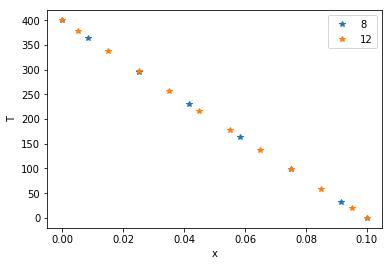

In [595]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '*', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

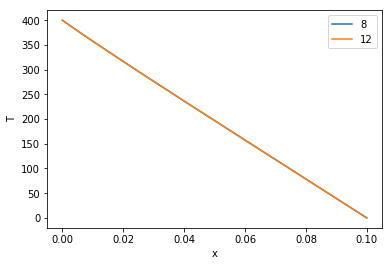

In [596]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '-', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

# Discussion on the Study of Grid Independence 
Even though above two graphs represent the same result, but they are presented in different ways. From the first graph, it is realizable that it represents the data for both 8 and 12 control volumes. The second graph also represent data for both 8 and 12 control volumes but as they have overlapped each other so it is difficult to differentiate from each other. From this, it can be concluded that 8 control volumes are enough to obtain a grid independent solution.

# Determination of Required Number of Iterations for Convergence for Wood

# Convergence Criteria 1e-8

In [597]:
def problem4implicitwood(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-8

    # Define thermophysical properties
    k = 0.1

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [598]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= (4*(i) + 6)*3
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitwood(ncv))

Iteration = 0; Max. Resid. = 0.26937; Avg. Resid. = 0.020559999999999995
Iteration = 1; Max. Resid. = 0.1004228480751021; Avg. Resid. = 0.010546473200674873
Iteration = 2; Max. Resid. = 0.011104371838062448; Avg. Resid. = 0.0017492342344775666
Iteration = 3; Max. Resid. = 0.000673560046126568; Avg. Resid. = 0.00012579180680299262
Iteration = 4; Max. Resid. = 5.874505966177272e-06; Avg. Resid. = 1.4888157344304365e-06
Iteration = 5; Max. Resid. = 1.0923462551160057e-09; Avg. Resid. = 3.480275361369336e-10
Iteration = 0; Max. Resid. = 0.44962199999999997; Avg. Resid. = 0.020352800000000008
Iteration = 1; Max. Resid. = 0.07165344385403861; Avg. Resid. = 0.006515606327301506
Iteration = 2; Max. Resid. = 0.0070944370111681275; Avg. Resid. = 0.000988982786028216
Iteration = 3; Max. Resid. = 0.00039185049462356174; Avg. Resid. = 7.34424710523231e-05
Iteration = 4; Max. Resid. = 3.471944545130161e-06; Avg. Resid. = 9.002627307594849e-07
Iteration = 5; Max. Resid. = 6.719712160839497e-10; Avg. 

# Convergence Criteria 1e-13

In [599]:
def problem4implicitwood(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-13

    # Define thermophysical properties
    k = 0.1

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [600]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= (4*(i) + 6)*3
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitwood(ncv))

Iteration = 0; Max. Resid. = 0.26937; Avg. Resid. = 0.020559999999999995
Iteration = 1; Max. Resid. = 0.1004228480751021; Avg. Resid. = 0.010546473200674873
Iteration = 2; Max. Resid. = 0.011104371838062448; Avg. Resid. = 0.0017492342344775666
Iteration = 3; Max. Resid. = 0.000673560046126568; Avg. Resid. = 0.00012579180680299262
Iteration = 4; Max. Resid. = 5.874505966177272e-06; Avg. Resid. = 1.4888157344304365e-06
Iteration = 5; Max. Resid. = 1.0923462551160057e-09; Avg. Resid. = 3.480275361369336e-10
Iteration = 6; Max. Resid. = 7.28583859910259e-17; Avg. Resid. = 2.798058110399805e-17
Iteration = 0; Max. Resid. = 0.44962199999999997; Avg. Resid. = 0.020352800000000008
Iteration = 1; Max. Resid. = 0.07165344385403861; Avg. Resid. = 0.006515606327301506
Iteration = 2; Max. Resid. = 0.0070944370111681275; Avg. Resid. = 0.000988982786028216
Iteration = 3; Max. Resid. = 0.00039185049462356174; Avg. Resid. = 7.34424710523231e-05
Iteration = 4; Max. Resid. = 3.471944545130161e-06; Avg. R

# Convergence Criteria 1e-16

In [601]:
def problem4implicitwood(ncv):   
    import numpy as np
    from numpy.linalg import norm

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-16

    # Define thermophysical properties
    k = 0.1

    # Define convection parameters
    #ho = 12
    To = 0
    sigma = 5.67e-8
    epsilon = 1
    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 100

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Create list to store the solutions at each iteration
    T_solns = [np.copy(T)]

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    Radiation = RadiationModelImplicit(grid, T, To, sigma, epsilon)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = Radiation.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

    return T

In [602]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(2):
    ncv= (4*(i) + 6)*3
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem4implicitwood(ncv))

Iteration = 0; Max. Resid. = 0.26937; Avg. Resid. = 0.020559999999999995
Iteration = 1; Max. Resid. = 0.1004228480751021; Avg. Resid. = 0.010546473200674873
Iteration = 2; Max. Resid. = 0.011104371838062448; Avg. Resid. = 0.0017492342344775666
Iteration = 3; Max. Resid. = 0.000673560046126568; Avg. Resid. = 0.00012579180680299262
Iteration = 4; Max. Resid. = 5.874505966177272e-06; Avg. Resid. = 1.4888157344304365e-06
Iteration = 5; Max. Resid. = 1.0923462551160057e-09; Avg. Resid. = 3.480275361369336e-10
Iteration = 6; Max. Resid. = 7.28583859910259e-17; Avg. Resid. = 2.798058110399805e-17
Iteration = 0; Max. Resid. = 0.44962199999999997; Avg. Resid. = 0.020352800000000008
Iteration = 1; Max. Resid. = 0.07165344385403861; Avg. Resid. = 0.006515606327301506
Iteration = 2; Max. Resid. = 0.0070944370111681275; Avg. Resid. = 0.000988982786028216
Iteration = 3; Max. Resid. = 0.00039185049462356174; Avg. Resid. = 7.34424710523231e-05
Iteration = 4; Max. Resid. = 3.471944545130161e-06; Avg. R

# Discussion on Determination of Required Number of Iterations for Convergence for Wood
Required number of iterations have been determined for wood. To do this, three convergence criteria were taken into consideration and these are 1e-8, 1e-13, 1e-16. After running the code for the above-mentioned convergence criteria, it was observed that:
### At convergence criteria 1e-8: 
Convergence takes place after 6 iterations (from 0 to 5). And it happened for both number of control volumes (i.e., ncv = 8 & ncv = 12)

### At convergence criteria 1e-13: 
Convergence takes place after 7 iterations (from 0 to 6). And it happened for both number of control volumes (i.e., ncv = 8 & ncv = 12)

### At convergence criteria 1e-16: 
Convergence takes place after 7 iterations (from 0 to 6). And it happened for both number of control volumes (i.e., ncv = 8 & ncv = 12)
### Conclusion: 
As for the last two consecutive convergence criteria i.e., 1e-13 and 1e-16, 7 iterations were enough for convergence to take place for both 8 and 12 control volumes, so required number of iterations for steel is determined to be 7.


# Study of Grid Independence 

In [603]:
import numpy as np
print(xPosition)
print(Temp)

[array([0.        , 0.00277778, 0.00833333, 0.01388889, 0.01944444,
       0.025     , 0.03055556, 0.03611111, 0.04166667, 0.04722222,
       0.05277778, 0.05833333, 0.06388889, 0.06944444, 0.075     ,
       0.08055556, 0.08611111, 0.09166667, 0.09722222, 0.1       ]), array([0.        , 0.00166667, 0.005     , 0.00833333, 0.01166667,
       0.015     , 0.01833333, 0.02166667, 0.025     , 0.02833333,
       0.03166667, 0.035     , 0.03833333, 0.04166667, 0.045     ,
       0.04833333, 0.05166667, 0.055     , 0.05833333, 0.06166667,
       0.065     , 0.06833333, 0.07166667, 0.075     , 0.07833333,
       0.08166667, 0.085     , 0.08833333, 0.09166667, 0.095     ,
       0.09833333, 0.1       ])]
[array([400.        , 302.36883855, 224.13084546, 181.22211337,
       153.41323704, 133.35931728, 117.73353901, 104.79761551,
        93.55031867,  83.37530408,  73.87680501,  64.79532936,
        55.96062968,  47.26322615,  38.63568149,  30.03933163,
        21.45438136,  12.87239724,   4.29

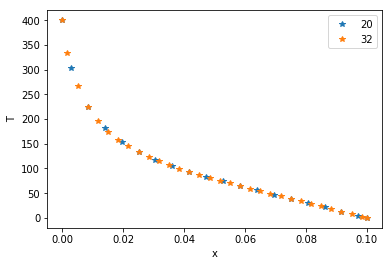

In [604]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '*', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

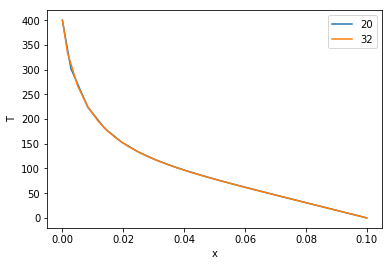

In [605]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '-', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

# Discussion on the Study of Grid Independence 
Even though above two graphs represent the same result, but they are presented in different ways. From the first graph, it is realizable that it represents the data for both 20 and 32 control volumes. The second graph also represents data for both 20 and 32 control volumes but as they have overlapped each other so it is difficult to differentiate from each other. From this, it can be concluded that 20 control volumes are enough to obtain a grid independent solution.
